In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import re                                  
import string  

import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Implementing Naive Bayes classifier

## Iteration 1:

1. First we setup the stopwords and tokenizer. Then we preprocess the dataset by tokenizing it, stems each token and filters out stopwords and punctuations. Then it extracts parts of the text and and counts the ocurrences.

In [ ]:
stopwords_english = set(stopwords.words('english') + list(string.punctuation))
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text)
    processed_text = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stopwords_english and word not in string.punctuation]
    return processed_text

def load_data(filename):
    return pd.read_excel(filename)

train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\MELD_train.xlsx"
test_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\MELD_test.xlsx"

train_d = pd.read_excel(train_path)
test_d = pd.read_excel(test_path)

2. What this does is extract the text from the sentence column and applies the preprocessing to it, collects processed texts, and the emotions. Then it returns a list of these features.

In [42]:
def extract_data(data):
    processed_texts = []
    emotions = data['Emotion'].tolist()
    for sentence in data['Sentence']:
        processed_text = preprocess(sentence)
        processed_texts.append(processed_text)
    return processed_texts, emotions

train_utterances, train_emotions = extract_data(train_d)
test_utterances, test_emotions = extract_data(test_d)


3. This constructs a frequency dictionary for word-emotion pairs accross the dataset.  

In [43]:
def build_freqs(utterances, emotions):
    freqs = {}
    for utterance, emotion in zip(utterances, emotions):
        for word in utterance:
            pair = (word, emotion)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

freqs = build_freqs(train_utterances, train_emotions)

4. This calculates the log probabilites needed for the naive bayes classification. 

vocab stores a set of unique words across all utterances.  
vocab_size is the number of unique words.  
emotion_counts is a dict that counts the ocurences of each emotion.  
logprior is a dict storing log prior probabilities for each emotion.  
probs is a dict storing log probs of observing each word given an emotion.  

In [44]:
def calculate_probabilities(freqs, utterances, emotions):
    vocab = set(word for utterance in utterances for word in utterance)
    vocab_size = len(vocab)
    emotion_counts = {emotion: emotions.count(emotion) for emotion in set(emotions)}
    
    probs = {}
    logprior = {}
    for emotion in emotion_counts:
        total_words = sum(freqs.get((word, emotion), 0) for word in vocab)
        logprior[emotion] = np.log(emotion_counts[emotion] / len(emotions))
        for word in vocab:
            word_count = freqs.get((word, emotion), 0)
            probs[(word, emotion)] = np.log((word_count + 1) / (total_words + vocab_size))
    
    return probs, logprior

probs, logprior = calculate_probabilities(freqs, train_utterances, train_emotions)


5. This predicts the emoion given the 'tweet' which in this case is a sentence from the dataset. 

In [45]:
def predict(tweet, probs, logprior, emotions):
    scores = {emotion: logprior.get(emotion, 0) for emotion in set(emotions)}
    for word in tweet:
        for emotion in scores:
            scores[emotion] += probs.get((word, emotion), 0)
    return max(scores, key=scores.get)

y_preds = [predict(tweet, probs, logprior, train_emotions) for tweet in test_utterances]

6. Lastly this prints out the scores from the predictions. 

In [46]:
y_test = test_emotions

print("Accuracy:", accuracy_score(y_test, y_preds))
print("Precision:", precision_score(y_test, y_preds, average='weighted'))
print("Recall:", recall_score(y_test, y_preds, average='weighted'))
print("F1 Score:", f1_score(y_test, y_preds, average='weighted'))

Accuracy: 0.5088122605363985
Precision: 0.4638105786732129
Recall: 0.5088122605363985
F1 Score: 0.4082951084830041


#### The Naive Bayes Classifier, as a prediction model is simple in its making. The reason why its called Naive is because of the fact that it assumes each feature used for the prediction are all independant of each other given the target class. With real-world data, such as the text data that is being, the features are not independant of each other and the presence and contextual placement of words in a sentence are highly dependant on the presence and knowing the context of other words. So that is what makes the Naive Bayes Classifier so simple, perhaps leading to a poor score.  

#### How it calculates and predicts: The log prior probability is calculated, in this case, by the count of one of the distinct emotions classes that there are divided by the total number of recorded emotions. Then the likelyhood of each word given a class is done using Laplacian smoothing to handle words that do not appear in data with any given class. To make the prediction, there is a score calculated for each class made from new preprocessed sentences from the dataset. The score of a class is the sum of the log prior of that class and the log likelihoods of each word in the text given the class, so basically we are calculating the class with the highest likelihoods of being the correct class given each new text from the dataset. The class with the highest score is selected as the prediction.  

#### This was just a step by step on how the naive bayes model works, the next iterations are the real ones that I tried:

------------------------

### From here on instead of only using the raw formulas, I used a supervised learning algoritm from scikit learn library. It's called MultinomialNB which subsititues the need to use all of the formulas individually and its perfect for tasks like text classification. I will be trying both methods from now on. 

## Iteration 2:

In [ ]:
# Setting stopwords and tokenizer
stopwords_english = set(stopwords.words('english') + list(string.punctuation))
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()

# Preprocessing function
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    processed_text = [stemmer.stem(word.lower()) for word in tokens if word not in string.punctuation]
    return processed_text

# Load data function
def load_data(filename):
    return pd.read_excel(filename)

# Paths to dataset
train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\MELD_train.xlsx"
test_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\MELD_test.xlsx"

# Load datasets
train_d = pd.read_excel(train_path)
test_d = pd.read_excel(test_path)

# Extract data function
def extract_data(data):
    processed_texts = []
    emotions = data['Emotion'].tolist()
    for sentence in data['Sentence']:
        processed_text = preprocess(sentence)
        processed_texts.append(processed_text)
    return processed_texts, emotions

# Extract training and testing data
train_utterances, train_emotions = extract_data(train_d)
test_utterances, test_emotions = extract_data(test_d)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = vectorizer.fit_transform(train_utterances)
X_test_tfidf = vectorizer.transform(test_utterances)

# SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, train_emotions)

# Train a Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_balanced, y_train_balanced)

# Predict on the test data
y_preds = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(test_emotions, y_preds))
print("Precision:", precision_score(test_emotions, y_preds, average='weighted'))
print("Recall:", recall_score(test_emotions, y_preds, average='weighted'))
print("F1 Score:", f1_score(test_emotions, y_preds, average='weighted'))

Accuracy: 0.3245210727969349
Precision: 0.4476517149386849
Recall: 0.3245210727969349
F1 Score: 0.35735858304096096


## Iteration 3

In [23]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


train = pd.read_csv(r"C:\Users\emilp\Downloads\train.txt", delimiter=';', header=None, names=['sentence','label'])
test = pd.read_csv(r"C:\Users\emilp\Downloads\test.txt", delimiter=';', header=None, names=['sentence','label'])

df_data = pd.concat([train, test])

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
df_data['Processed_Sentence'] = df_data['sentence'].astype(str).apply(preprocess)

# Features (X) and Labels (y)
X = df_data['Processed_Sentence']
y = df_data['label']

# Convert Text to Numerical Features using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))  
X_vectorized = vectorizer.fit_transform(X)

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.30, random_state=5)

# Train Multinomial Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make Predictions
predicted = mnb.predict(X_test)

# Evaluate Model
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

print(df_data['label'].count())

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

18000
Accuracy: 0.767962962962963
Precision: 0.833348195575709
Recall: 0.5814664741567024
F1 Score: 0.61606532054869


## Iteration 4:

In [24]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_5\FINAL_DATASET.xlsx"
#test_path = r"C:\Users\emilp\Downloads\test.txt" # Change to actual file path

# Adjust `sep` based on file format (`\t` for tab, `,` for CSV-like text files)
train_d = pd.read_excel(train_path)  

df_data = pd.concat([train_d])

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
df_data['Processed_Sentence'] = df_data['Translation'].astype(str).apply(preprocess)

# Features (X) and Labels (y)
X = df_data['Processed_Sentence']
y = df_data['Corrected_Emotion']

# Convert Text to Numerical Features using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))  
X_vectorized = vectorizer.fit_transform(X)

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.30, random_state=5)

# Train Multinomial Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make Predictions
predicted = mnb.predict(X_test)

# Evaluate Model
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

print(df_data['Corrected_Emotion'].count())

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

3855
Accuracy: 0.6447709593777009
Precision: 0.31319596499035746
Recall: 0.22399310825685617
F1 Score: 0.22812123974909607


c:\Users\emilp\anaconda3\envs\block_d\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Iteration 5:

In [11]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\ver_2_FINAL_DATASET.xlsx"
#test_path = r"C:\Users\emilp\Downloads\test.txt" # Change to actual file path

# Adjust `sep` based on file format (`\t` for tab, `,` for CSV-like text files)
train_d = pd.read_excel(train_path)  

df_data = pd.concat([train_d])

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
df_data['Processed_Sentence'] = df_data['Sentence'].astype(str).apply(preprocess)

# Features (X) and Labels (y)
X = df_data['Processed_Sentence']
y = df_data['main_category']

# Convert Text to Numerical Features using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))  
X_vectorized = vectorizer.fit_transform(X)

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.30, random_state=5)

# Train Multinomial Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make Predictions
predicted = mnb.predict(X_test)

# Evaluate Model
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

print(df_data['main_category'].unique())

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']

['happiness' 'disgust' 'anger' 'surprise' 'sadness' 'fear' 'neutral']
Accuracy: 0.34528076463560337
Precision: 0.34205492519236236
Recall: 0.34458379329406547
F1 Score: 0.3391202103597467


## Iteration 6:

In [15]:
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\ver_2_FINAL_DATASET.xlsx"
#test_path = r"C:\Users\emilp\Downloads\test.txt" # Change to actual file path

# Adjust `sep` based on file format (`\t` for tab, `,` for CSV-like text files)
train_d = pd.read_excel(train_path)  

df_data = pd.concat([train_d])

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
df_data['Processed_Sentence'] = df_data['Sentence'].astype(str).apply(preprocess)

# Features (X) and Labels (y)
X = df_data['Processed_Sentence']
y = df_data['main_category']

# Convert Text to Numerical Features using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))  
X_vectorized = vectorizer.fit_transform(X)

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.20, random_state=42)

# Train Multinomial Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make Predictions
predicted = mnb.predict(X_test)

# Evaluate Model
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

print(df_data['main_category'].unique())

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

['happiness' 'disgust' 'anger' 'surprise' 'sadness' 'fear' 'neutral']
Accuracy: 0.37455197132616486
Precision: 0.37210061606343187
Recall: 0.37210568112369596
F1 Score: 0.36994076443776874


## Iteration 7:

In [ ]:
emotion_mapping = {
    'joy': 'happiness',  # Merging similar emotions
    'happiness': 'happiness', 
    'sadness': 'sadness',
    'anger': 'anger',
    'fear': 'fear',
    'surprise': 'surprise',
    'disgust': 'disgust',
}

train1 = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\ver_2_FINAL_DATASET.xlsx"

train2 = pd.read_csv(r"C:\Users\emilp\Downloads\train.txt", delimiter=';', header=None, names=['sentence','label'])
test2 = pd.read_csv(r"C:\Users\emilp\Downloads\test.txt", delimiter=';', header=None, names=['sentence','label'])

# Adjust `sep` based on file format (`\t` for tab, `,` for CSV-like text files)
train_d1 = pd.read_excel(train1)  
df1 = pd.concat([train_d1])

df2 = pd.concat([train2, test2], ignore_index=True)

df1.rename(columns={'main_category': 'label'}, inplace=True)
train_d1.rename(columns={'Sentence': 'sentence'}, inplace=True)

df1['label'] = df1['label'].map(emotion_mapping)
df2['label'] = df2['label'].map(emotion_mapping)

df1 = df1.dropna(subset=['label'])
df2 = df2.dropna(subset=['label'])

df_combined = pd.concat([df1, df2], ignore_index=True)

df_combined = df_combined.dropna(subset=['sentence'])  # Remove missing sentences

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
df_combined['Processed_Sentence'] = df_combined['sentence'].astype(str).apply(preprocess)

# Features (X) and Labels (y)
X = df_combined['Processed_Sentence']
y = df_combined['label']

# Convert text to vector representation (e.g., TF-IDF)
vectorizer = CountVectorizer(stop_words='english')
X_vectorized = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Multinomial Naive Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train_smote, y_train_smote)

# Make Predictions
predicted = mnb.predict(X_test)

# Evaluate Model
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Save the model to disk
model_filename = 'test_model_download.joblib'
dump(mnb, model_filename)


Accuracy: 0.8663845223700121
Precision: 0.8039725154050344
Recall: 0.8088668684159959
F1 Score: 0.8059023148597302


['test_model_download.joblib']

### Iteration 8: Model using sentiment score nlp function:

The way its integrated is since Multinommial Naive Bayes requires non negative numbers as input, so I have had to scale the numbers to be within a range of 0-1 so that it works. And they're also reshaped to fit the requirements of the scaler. 

In [53]:
import pandas as pd
import numpy as np
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack  # To combine sparse matrices

# Load dataset
train_path = r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\ver_2_FINAL_DATASET.xlsx"
df_data = pd.read_excel(train_path)

# Text Preprocessing
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stemmer = PorterStemmer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lowercase
    return " ".join(tokens)  # Convert list back to string for vectorization

# Apply preprocessing
from sklearn.preprocessing import MinMaxScaler

# Preprocess text
df_data['Processed_Sentence'] = df_data['Sentence'].astype(str).apply(preprocess)

# Convert Text to Numerical Features using CountVectorizer
X_text = df_data['Processed_Sentence']
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))
X_vectorized = vectorizer.fit_transform(X_text)

# Normalize sentiment scores to be non-negative
X_sentiment = df_data['Sentiment_Score'].values.reshape(-1, 1)
scaler = MinMaxScaler()
X_sentiment_scaled = scaler.fit_transform(X_sentiment)

# Combine text features with scaled sentiment scores
X_combined = hstack([X_vectorized, X_sentiment_scaled])

# Split and Train
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.20, random_state=42)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make Predictions and Evaluate
predicted = mnb.predict(X_test)
acc_score = accuracy_score(y_test, predicted)
prec_score = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

# Print Results
print(f"Accuracy: {acc_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.3709677419354839
Precision: 0.36937384913024596
Recall: 0.3685666576447219
F1 Score: 0.3662866122551737


## Iteration 9:

In [31]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.corpus import stopwords
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from joblib import dump

# Initialize tokenizer and stemmer
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
stopwords_english = set(stopwords.words('english') + list(string.punctuation))

# Define preprocessing function
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stopwords_english and word not in string.punctuation]

# Load and prepare datasets
train1 = pd.read_excel(r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Task_4\ver_2_FINAL_DATASET.xlsx")
train2 = pd.read_csv(r"C:\Users\emilp\Downloads\train.txt", delimiter=';', header=None, names=['sentence','label'])
test2 = pd.read_csv(r"C:\Users\emilp\Downloads\test.txt", delimiter=';', header=None, names=['sentence','label'])

train_d1 = pd.concat([train1])
df2 = pd.concat([train2, test2], ignore_index=True)

train_d1.rename(columns={'main_category': 'label'}, inplace=True)
train_d1.rename(columns={'Sentence': 'sentence'}, inplace=True)
emotion_mapping = {
    'joy': 'happiness', 
    'happiness': 'happiness', 
    'sadness': 'sadness',
    'anger': 'anger',
    'fear': 'fear',
    'surprise': 'surprise',
    'disgust': 'disgust',
    'neutral':'neutral'
}
train_d1['label'] = train_d1['label'].map(emotion_mapping)
df2['label'] = df2['label'].map(emotion_mapping)

df_combined = pd.concat([train_d1, df2], ignore_index=True).dropna(subset=['sentence', 'label'])

# Extract data
def extract_data(data):
    processed_texts = []
    labels = data['label'].tolist()
    for sentence in data['sentence']:
        processed_text = preprocess(sentence)
        processed_texts.append(processed_text)
    return processed_texts, labels

utterances, labels = extract_data(df_combined)

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(utterances, labels, test_size=0.2, random_state=42)

# Building frequency dictionary
def build_freqs(utterances, labels):
    freqs = {}
    for utterance, label in zip(utterances, labels):
        for word in utterance:
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

freqs = build_freqs(train_data, train_labels)

# Calculate probabilities
def calculate_probabilities(freqs, utterances, labels):
    vocab = set(word for utterance in utterances for word in utterance)
    vocab_size = len(vocab)
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    probs = {}
    logprior = {}
    for label in label_counts:
        total_words = sum(freqs.get((word, label), 0) for word in vocab)
        logprior[label] = np.log(label_counts[label] / len(labels))
        for word in vocab:
            word_count = freqs.get((word, label), 0)
            probs[(word, label)] = np.log((word_count + 1) / (total_words + vocab_size))
    
    return probs, logprior

probs, logprior = calculate_probabilities(freqs, train_data, train_labels)

# Prediction function
def predict(utterance, probs, logprior, labels):
    scores = {label: logprior.get(label, 0) for label in set(labels)}
    for word in utterance:
        for label in scores:
            scores[label] += probs.get((word, label), 0)
    return max(scores, key=scores.get)

# Testing on test data
y_preds = [predict(utterance, probs, logprior, train_labels) for utterance in test_data]

# Evaluation
print("Accuracy:", accuracy_score(test_labels, y_preds))
print("Precision:", precision_score(test_labels, y_preds, average='weighted'))
print("Recall:", recall_score(test_labels, y_preds, average='weighted'))
print("F1 Score:", f1_score(test_labels, y_preds, average='weighted'))

# Optionally, save the model
model_filename = 'naive_bayes_model_2.joblib'
dump((probs, logprior), model_filename)


Accuracy: 0.6819620253164557
Precision: 0.6564554858293112
Recall: 0.6819620253164557
F1 Score: 0.6417279176164461


['naive_bayes_model_2.joblib']

## Iteration 10:

In [50]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.corpus import stopwords
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from joblib import dump

# Initialize tokenizer and stemmer
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
stopwords_english = set(stopwords.words('english') + list(string.punctuation))

# Define preprocessing function
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stopwords_english and word not in string.punctuation]

# Load and prepare datasets
train1 = pd.read_csv(r"C:\Users\emilp\Documents\GitHub\2024-25c-fai2-adsai-group-group16\Data\cropped_df.csv")

df_combined = pd.concat([train1])

# Extract data
def extract_data(data):
    processed_texts = []
    labels = data['main_category'].tolist()
    for sentence in data['text']:
        processed_text = preprocess(sentence)
        processed_texts.append(processed_text)
    return processed_texts, labels

utterances, labels = extract_data(df_combined)

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(utterances, labels, test_size=0.2, random_state=42)

# Building frequency dictionary
def build_freqs(utterances, labels):
    freqs = {}
    for utterance, label in zip(utterances, labels):
        for word in utterance:
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

freqs = build_freqs(train_data, train_labels)

# Calculate probabilities
def calculate_probabilities(freqs, utterances, labels):
    vocab = set(word for utterance in utterances for word in utterance)
    vocab_size = len(vocab)
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    probs = {}
    logprior = {}
    for label in label_counts:
        total_words = sum(freqs.get((word, label), 0) for word in vocab)
        logprior[label] = np.log(label_counts[label] / len(labels))
        for word in vocab:
            word_count = freqs.get((word, label), 0)
            probs[(word, label)] = np.log((word_count + 1) / (total_words + vocab_size))
    
    return probs, logprior

probs, logprior = calculate_probabilities(freqs, train_data, train_labels)

# Prediction function
def predict(utterance, probs, logprior, labels):
    scores = {label: logprior.get(label, 0) for label in set(labels)}
    for word in utterance:
        for label in scores:
            scores[label] += probs.get((word, label), 0)
    return max(scores, key=scores.get)

# Testing on test data
y_preds = [predict(utterance, probs, logprior, train_labels) for utterance in test_data]

# Evaluation
print("Accuracy:", accuracy_score(test_labels, y_preds))
print("Precision:", precision_score(test_labels, y_preds, average='weighted'))
print("Recall:", recall_score(test_labels, y_preds, average='weighted'))
print("F1 Score:", f1_score(test_labels, y_preds, average='weighted'))

# Optionally, save the model
model_filename = 'naive_bayes_model_3_cropdf.joblib'
dump((probs, logprior), model_filename)

Accuracy: 0.805067385444744
Precision: 0.8041466206290159
Recall: 0.805067385444744
F1 Score: 0.8033414486699348


['naive_bayes_model_3_cropdf.joblib']

Classification Report:
               precision    recall  f1-score   support

       anger       0.82      0.82      0.82      1346
     disgust       0.87      0.99      0.93      1287
        fear       0.78      0.82      0.80      1304
   happiness       0.82      0.72      0.76      1342
     neutral       0.79      0.71      0.75      1325
     sadness       0.80      0.80      0.80      1332
    surprise       0.76      0.79      0.77      1339

    accuracy                           0.81      9275
   macro avg       0.80      0.81      0.80      9275
weighted avg       0.80      0.81      0.80      9275



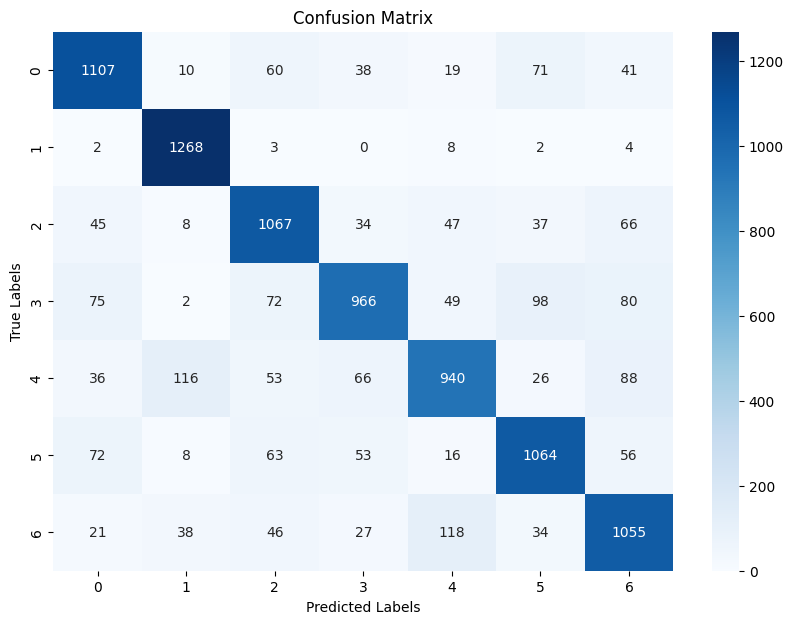

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(test_labels, y_preds)
print("Classification Report:\n", report)

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_preds)

# Optionally, you can plot the confusion matrix for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Prediction check for Iteration 10:

### I give it a few sentences that I wrote on the spot and it has to predict what emotion the sentence I wrote is

In [24]:
# Initialize tokenizer and stemmer
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
stopwords_english = set(stopwords.words('english') + list(string.punctuation))

# Define preprocessing function
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stopwords_english and word not in string.punctuation]

# Prediction function
def predict(utterance, probs, logprior, labels):
    scores = {label: logprior.get(label, 0) for label in set(labels)}
    for word in utterance:
        for label in scores:
            if (word, label) in probs:
                scores[label] += probs[(word, label)]
    return max(scores, key=scores.get)

# Load the model from disk
model_path = 'naive_bayes_model_3_cropdf.joblib'
probs, logprior = load(model_path)

# Example new sentences
new_sentences = [
    "I am so happy with the results!",
    "This is terrible, I can't believe it happened.",
    "What a pleasant surprise!",
    "ugh what disgusting!",
    "hello there sir",
    "im so surprised!",
    "well that is not fucking creepy",
    "ewww thats gross so disgusting",
    "hello there"
]

# Preprocess and predict
new_data = [preprocess(sentence) for sentence in new_sentences]
predicted_emotions = [predict(data, probs, logprior, set(logprior.keys())) for data in new_data]

# Print the predictions
for sentence, emotion in zip(new_sentences, predicted_emotions):
    print(f"Sentence: {sentence}\nPredicted Emotion: {emotion}\n")

Sentence: I am so happy with the results!
Predicted Emotion: anger

Sentence: This is terrible, I can't believe it happened.
Predicted Emotion: sadness

Sentence: What a pleasant surprise!
Predicted Emotion: surprise

Sentence: ugh what disgusting!
Predicted Emotion: anger

Sentence: hello there sir
Predicted Emotion: neutral

Sentence: im so surprised!
Predicted Emotion: surprise

Sentence: well that is not fucking creepy
Predicted Emotion: anger

Sentence: ewww thats gross so disgusting
Predicted Emotion: anger

Sentence: hello there
Predicted Emotion: neutral

